In [1]:
# # install if you don't have these libraries
# !pip install librosa
# !pip install noisereduce
# !pip install soundfile

# Step 1 - Import necessary libraries and set up the project directory

In [2]:
import os
import librosa
import noisereduce as nr
import soundfile as sf
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model

In [3]:
# Path to the dataset
Crema = "/Users/rong/Desktop/deep_learning/final project/archive/Crema"

In [4]:
# List files in the directory
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

# Iterate over each file and extract emotion and path
for file in crema_directory_list:
    full_path = os.path.join(Crema, file)
    if not os.path.exists(full_path):
        print(f"File not found: {full_path}")
        continue  # Skip to the next file if the file does not exist
        
    # storing file paths
    file_path.append(full_path)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# Create DataFrame for emotion and file paths
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,sad,/Users/rong/Desktop/deep_learning/final projec...
1,angry,/Users/rong/Desktop/deep_learning/final projec...
2,happy,/Users/rong/Desktop/deep_learning/final projec...
3,fear,/Users/rong/Desktop/deep_learning/final projec...
4,angry,/Users/rong/Desktop/deep_learning/final projec...


In [5]:
unique_emotions = Crema_df['Emotions'].unique()
print(f"Unique emotions: {unique_emotions}")

Unique emotions: ['sad' 'angry' 'happy' 'fear' 'neutral' 'disgust']


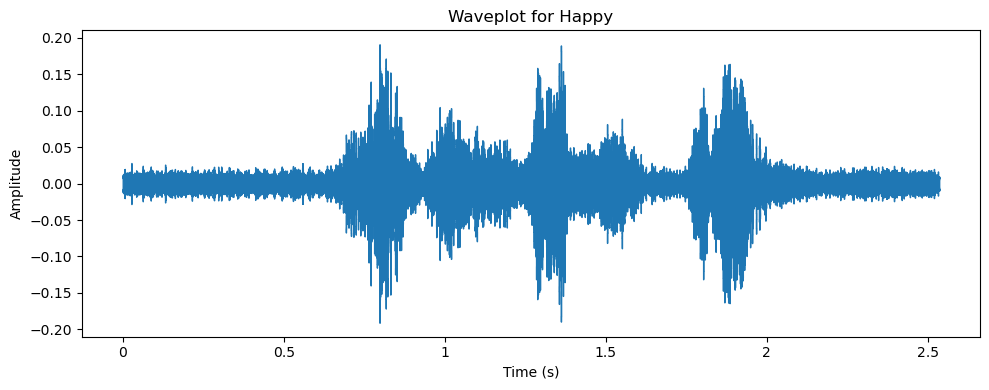

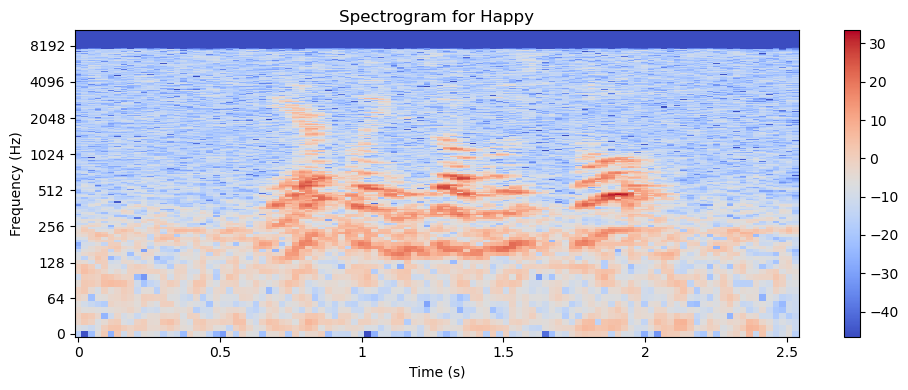

In [6]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# Function to create a waveplot
def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.title(f'Waveplot for {emotion.capitalize()}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Function to create a spectrogram
def create_spectrogram(data, sampling_rate, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.title(f'Spectrogram for {emotion.capitalize()}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

# Example usage:
emotion = 'happy'
path = np.array(Crema_df.Path[Crema_df.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

# To play the audio
from IPython.display import Audio
Audio(path)


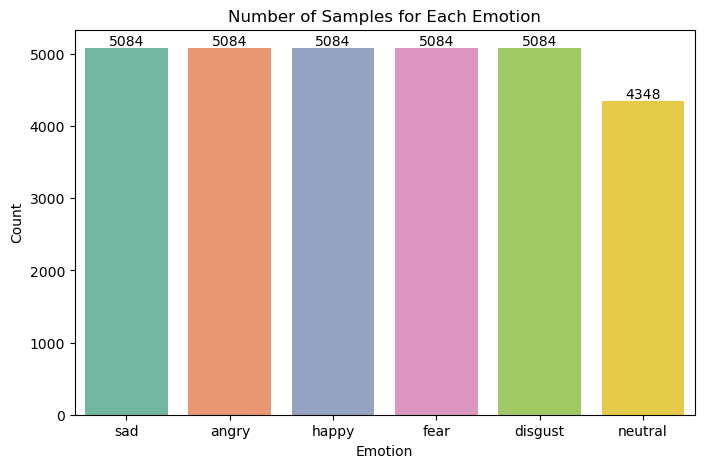

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of each emotion
emotion_counts = Crema_df['Emotions'].value_counts().reset_index()
emotion_counts.columns = ['Emotion', 'Count']

# Create the bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='Emotion', y='Count', data=emotion_counts, palette='Set2')

# Add the exact number on top of each bar
for index, row in emotion_counts.iterrows():
    plt.text(index, row['Count'], str(row['Count']), ha='center', va='bottom')

# Customize the plot
plt.title('Number of Samples for Each Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')


# Show the plot
plt.show()


# Step 2 - Extract features from the audio files

In [8]:
def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path, sr=None)
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    
#     # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)
    
    # Extract Spectral Contrast features
    # contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    # contrast_mean = np.mean(contrast.T, axis=0)
    
    # Extract Zero-Crossing Rate
    zero_crossing = librosa.feature.zero_crossing_rate(y)
    zero_crossing_mean = np.mean(zero_crossing.T, axis=0)
    
#     # Extract Root Mean Square (RMS) Energy features
#     rms = librosa.feature.rms(y=y)[0]
#     rms_mean = np.mean(rms.T, axis=0)
    
#     # Extract mel_spectrogram Energy features
#     mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
#     mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
#     mel_spectrogram_db_mean = np.mean(mel_spectrogram_db.T, axis=0)
    
    # Combine all features
    combined_features = np.hstack([mfccs_mean, chroma_mean, zero_crossing_mean])
    return combined_features

# Extract features for each file in the DataFrame
Crema_df['Features'] = Crema_df['Path'].apply(lambda x: extract_features(x))
Crema_df.head()


/Users/rong/anaconda3/lib/python3.11/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


,Emotions,Path,Features
0,sad,/Users/rong/Desktop/deep_learning/final projec...,"[-254.75794982910156, 48.863128662109375, 30.9..."
1,angry,/Users/rong/Desktop/deep_learning/final projec...,"[-236.38174438476562, 83.46347045898438, 16.29..."
2,happy,/Users/rong/Desktop/deep_learning/final projec...,"[-408.2060241699219, 106.76225280761719, 34.02..."
3,fear,/Users/rong/Desktop/deep_learning/final projec...,"[-407.93536376953125, 85.49365234375, 52.21398..."
4,angry,/Users/rong/Desktop/deep_learning/final projec...,"[-309.6947937011719, 98.22966003417969, 34.212..."


Augmentation

In [9]:
# import os
# import librosa
# import numpy as np
# import pandas as pd
# import soundfile as sf

# # Path to the dataset
# Crema = "/Users/rong/Desktop/deep_learning/final project/archive/Crema"

# # List files in the directory
# crema_directory_list = os.listdir(Crema)

# # Data augmentation functions
# def add_noise(data, noise_factor=0.005):
#     noise = np.random.randn(len(data))
#     augmented_data = data + noise_factor * noise
#     return augmented_data.astype(type(data[0]))

# def change_pitch(data, sampling_rate, pitch_factor=2):
#     return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# def change_speed(data, speed_factor=1.5):
#     return librosa.effects.time_stretch(data, rate=speed_factor)

# def augment_audio(file_path, augmentations):
#     y, sr = librosa.load(file_path, sr=None)
#     augmented_audios = []
#     for augmentation in augmentations:
#         if augmentation == "noise":
#             augmented_audios.append(add_noise(y))
#         elif augmentation == "pitch":
#             augmented_audios.append(change_pitch(y, sr))
#         elif augmentation == "speed":
#             augmented_audios.append(change_speed(y))
#     return augmented_audios, sr

# # Initial DataFrame
# file_emotion = []
# file_path = []

# # Iterate over each file and extract emotion and path
# for file in crema_directory_list:
#     full_path = os.path.join(Crema, file)
#     if not os.path.exists(full_path):
#         print(f"File not found: {full_path}")
#         continue
    
#     # Storing file paths
#     file_path.append(full_path)
#     # Storing file emotions
#     part = file.split('_')
#     if part[2] == 'SAD':
#         file_emotion.append('sad')
#     elif part[2] == 'ANG':
#         file_emotion.append('angry')
#     elif part[2] == 'DIS':
#         file_emotion.append('disgust')
#     elif part[2] == 'FEA':
#         file_emotion.append('fear')
#     elif part[2] == 'HAP':
#         file_emotion.append('happy')
#     elif part[2] == 'NEU':
#         file_emotion.append('neutral')
#     else:
#         file_emotion.append('Unknown')

# # Create initial DataFrame
# emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# path_df = pd.DataFrame(file_path, columns=['Path'])
# Crema_df = pd.concat([emotion_df, path_df], axis=1)

# # Perform Data Augmentation
# augmented_emotions = []
# augmented_paths = []

# for file in crema_directory_list:
#     full_path = os.path.join(Crema, file)
#     if not os.path.exists(full_path):
#         continue
    
#     part = file.split('_')
#     emotion = None
#     if part[2] == 'SAD':
#         emotion = 'sad'
#     elif part[2] == 'ANG':
#         emotion = 'angry'
#     elif part[2] == 'DIS':
#         emotion = 'disgust'
#     elif part[2] == 'FEA':
#         emotion = 'fear'
#     elif part[2] == 'HAP':
#         emotion = 'happy'
#     elif part[2] == 'NEU':
#         emotion = 'neutral'
#     else:
#         emotion = 'Unknown'
    
#     augmented_audios, sr = augment_audio(full_path, ["noise", "pitch", "speed"])
    
#     for i, augmented_audio in enumerate(augmented_audios):
#         augmented_file_path = f"{full_path.split('.wav')[0]}_aug_{i}.wav"
#         sf.write(augmented_file_path, augmented_audio, sr)
#         augmented_paths.append(augmented_file_path)
#         augmented_emotions.append(emotion)   
        
# print("Creation of augmented files completed.")

In [10]:
# # Append augmented data to DataFrame
# augmented_df = pd.DataFrame({
#     'Emotions': augmented_emotions,
#     'Path': augmented_paths
# })
# Crema_df = pd.concat([Crema_df, augmented_df], ignore_index=True)

In [11]:
# # Run this cell If you want to delete all the augmented audio files that were created with a specific suffix

# import os

# # Path to the dataset
# Crema = "/Users/rong/Desktop/deep_learning/final project/archive/Crema"

# # List files in the directory
# crema_directory_list = os.listdir(Crema)

# # Define the suffix for augmented files
# augmented_suffix = "_aug_"

# # Iterate over the files and delete augmented ones
# for file in crema_directory_list:
#     if augmented_suffix in file:
#         file_path = os.path.join(Crema, file)
#         try:
#             os.remove(file_path)
           
#         except Exception as e:
#             print(f"Error deleting file {file_path}: {e}")

# print("Deletion of augmented files completed.")


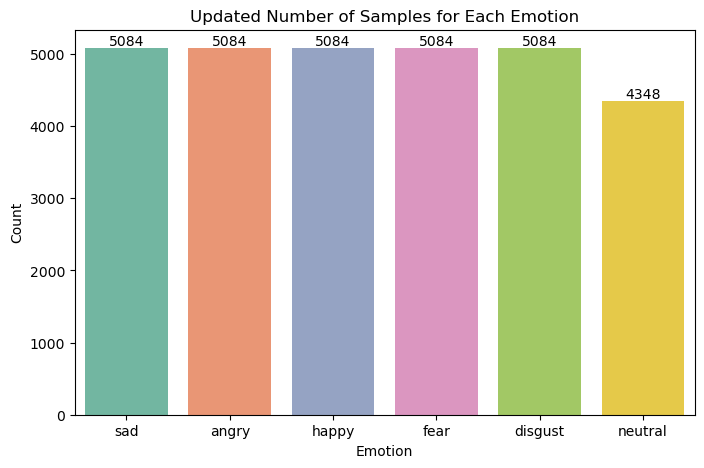

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot updated data distribution
updated_emotion_counts = Crema_df['Emotions'].value_counts().reset_index()
updated_emotion_counts.columns = ['Emotion', 'Count']

plt.figure(figsize=(8, 5))
sns.barplot(x='Emotion', y='Count', data=updated_emotion_counts, palette='Set2')

for index, row in updated_emotion_counts.iterrows():
    plt.text(index, row['Count'], str(row['Count']), ha='center', va='bottom')

plt.title('Updated Number of Samples for Each Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()


# Step 3 - Convert the feature list to a NumPy array and one-hot encode the labels

In [13]:
# Convert features to a list of arrays
X = np.array(Crema_df['Features'].tolist())

# Encode the labels
encoder = OneHotEncoder()
y = encoder.fit_transform(Crema_df[['Emotions']]).toarray()

# Save the encoder
joblib.dump(encoder, 'label_encoder.joblib')


['label_encoder.joblib']

# Step 4 - Split the data into training and testing sets

In [14]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for LSTM input: (samples, timesteps, features)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]


# Step 5 - Build the model

CNN 2D + LSTM model

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Flatten, Dense, Dropout, Input, Reshape

# Example reshape for 2D convolution (26x1 -> 13x2)
X_train_reshaped = X_train.reshape((X_train.shape[0], 13, 2, 1))  # Reshape to (13, 2) with 1 channel
X_test_reshaped = X_test.reshape((X_test.shape[0], 13, 2, 1))

# Define the model
inputs = Input(shape=(13, 2, 1))  # Example input shape for 2D CNN
x = Conv2D(32, (2, 2), activation='relu', padding='same')(inputs)  # Kernel size adjusted to (2, 2)
x = MaxPooling2D((2, 1))(x)  # Use pooling window that fits dimensions
x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 1))(x)
x = Flatten()(x)  # Flatten the output

# If you want to use LSTM, make sure to reshape appropriately
x = Reshape((x.shape[1] // 64, 64))(x)  # Assuming here 64 as the feature size

# Add LSTM layer
x = LSTM(128, return_sequences=False)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(y_train.shape[1], activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# print(model.summary())


In [16]:
# Set Up Model Checkpointing and Learning Rate Scheduling
# Model checkpointing to save the best model
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Learning rate scheduler to reduce learning rate after 10 epochs
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler_callback = LearningRateScheduler(scheduler)


# Step 6 - Train the model using the extracted features

In [17]:
# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[model_checkpoint_callback, lr_scheduler_callback]
)


Epoch 1/50
731/745 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3150 - loss: 1.6078
Epoch 1: val_accuracy improved from -inf to 0.32062, saving model to best_model.keras
745/745 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3155 - loss: 1.6068 - val_accuracy: 0.3206 - val_loss: 1.6385 - learning_rate: 0.0010
Epoch 2/50
735/745 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3686 - loss: 1.5146
Epoch 2: val_accuracy improved from 0.32062 to 0.37756, saving model to best_model.keras
745/745 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3688 - loss: 1.5144 - val_accuracy: 0.3776 - val_loss: 1.4838 - learning_rate: 0.0010
Epoch 3/50
733/745 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3891 - loss: 1.4750
Epoch 3: val_accuracy improved from 0.37756 to 0.40275, saving model to best_model.keras
745/745 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3891 - loss: 1.4750 - val_accuracy: 0.4028 - val_loss: 1.4319 - learning_rate: 0.0010
Epoch 4/50
741/745 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - a

# Step 7 - Evaluate the model on the test set and plot the results

In [18]:
# Load the best model

best_model = load_model('best_model.keras')

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test_reshaped, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')
model.summary()


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.4960 - loss: 1.4324
Test Accuracy: 0.49


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13, 2, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 13, 2, 32)      │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 2, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,636 (1.33 MB)

 Trainable params: 115,878 (452.65 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 231,758 (905.31 KB)

# Step 8 - Plot Evaluation

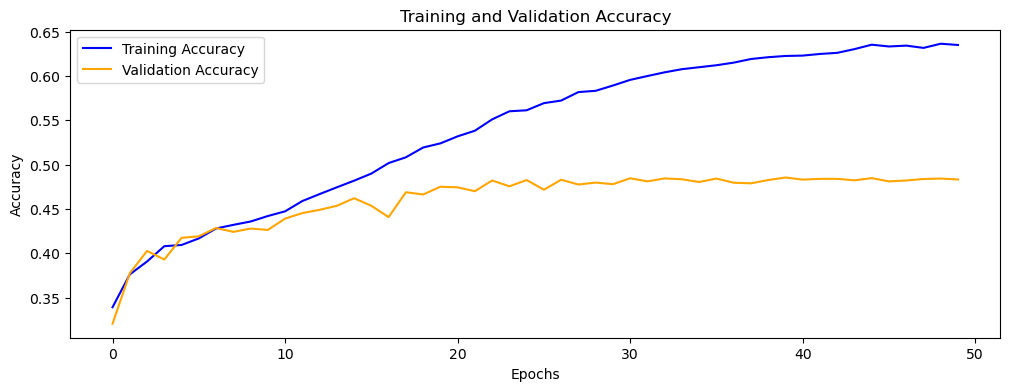

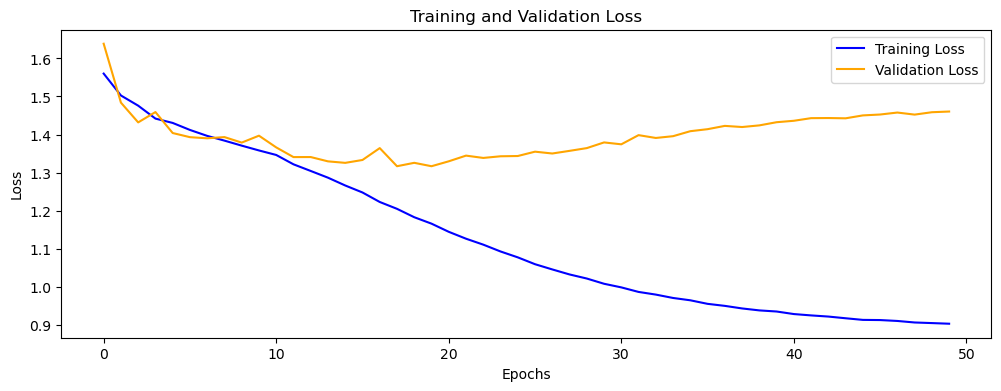

In [19]:
# Plot training and validation accuracy
epochs = range(len(history.history['accuracy']))
plt.figure(figsize=(12, 4))
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


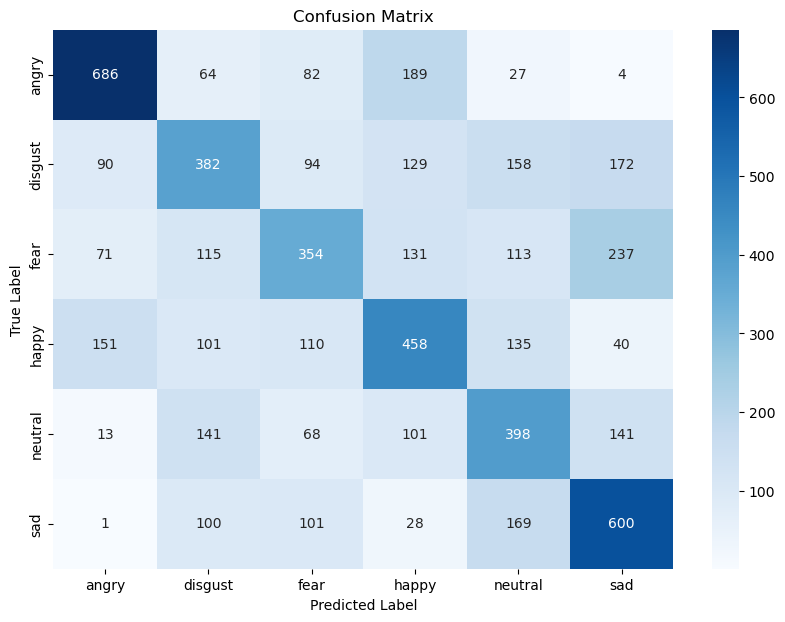

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
cm_df = pd.DataFrame(cm, index=encoder.categories_[0], columns=encoder.categories_[0])

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# Prediction

In [36]:
# Predict Emotions for All Files in a Folder

# Define the mapping from file prefixes to emotions
prefix_to_emotion = {
    'a': 'angry',
    'd': 'disgust',
    'f': 'fear',
    'h': 'happy',
    'n': 'neutral',
    'sa': 'sad',
    'su': None  # Exclude 'su' from the list
}

# Path to the folder containing the .wav files
folder_path = '/Users/rong/Desktop/deep_learning/final project/archive/Savee' 
# List all files in the folder
wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav') and not f.split('_')[1].startswith('su')]

results = []

for file_name in wav_files:
    file_path = os.path.join(folder_path, file_name)

    features = extract_features(file_path)
    # Reshape to match model input shape
    features = features.reshape(1, 13, 2, 1)  # Adjust this to match your model's input shape
    
    # Predict emotion
    predicted_probabilities = model.predict(features)
    predicted_emotion = encoder.inverse_transform(predicted_probabilities)

    # Extract the actual emotion from the file name
    prefix = file_name.split('_')[1]
    if len(prefix) >= 2 and prefix[:2] in prefix_to_emotion:
        actual_emotion_prefix = prefix[:2]
    else:
        actual_emotion_prefix = prefix[0]
        
    actual_emotion = prefix_to_emotion.get(actual_emotion_prefix, 'Unknown')

     # Check if the prediction is correct
    correct = (predicted_emotion[0] == actual_emotion)

     # Append results
    results.append({
        'file_name': file_name,
        'actual_emotion': actual_emotion,
        'predicted_emotion': predicted_emotion[0],
        'correct': correct
    })

    print(f"Audio File: {file_name}, Actual Emotion: {actual_emotion}, Predicted Emotion: {predicted_emotion[0]}")
    
    
# Create DataFrame from results
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Audio File: JK_sa01.wav, Actual Emotion: sad, Predicted Emotion: ['neutral']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Audio File: JK_sa15.wav, Actual Emotion: sad, Predicted Emotion: ['neutral']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Audio File: DC_n13.wav, Actual Emotion: neutral, Predicted Emotion: ['sad']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Audio File: DC_n07.wav, Actual Emotion: neutral, Predicted Emotion: ['sad']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Audio File: JK_n20.wav, Actual Emotion: neutral, Predicted Emotion: ['neutral']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Audio File: JK_n08.wav, Actual Emotion: neutral, Predicted Emotion: ['neutral']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Audio File: JE_sa08.wav, Actual Emotion: sad, Predicted Emotion: ['neutral']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Audio File: JK_f15.wav, Actual Emotion: fear, Predicted Emotion: ['happy']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Audio File: JK_f01.wav, Actual Emotion: fear,

In [33]:
results_df.head(15)

,file_name,actual_emotion,predicted_emotion,correct
0,JK_sa01.wav,sad,[neutral],[False]
1,JK_sa15.wav,sad,[neutral],[False]
2,DC_n13.wav,neutral,[sad],[False]
3,DC_n07.wav,neutral,[sad],[False]
4,JK_n20.wav,neutral,[neutral],[True]
5,JK_n08.wav,neutral,[neutral],[True]
6,JE_sa08.wav,sad,[neutral],[False]
7,JK_f15.wav,fear,[happy],[False]
8,JK_f01.wav,fear,[happy],[False]
9,KL_sa13.wav,sad,[sad],[True]


In [28]:
# num_true = results_df['correct'].sum()
# total_count = results_df['correct'].count()
# percentage_true = (num_true / total_count) * 100
# percentage_true